# More detailed walkthrough

See the simple walkthrough for a quicker introduction to the PyDDM package. Here, we will go into a little more depth.

<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

## Importing the necessary modules

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
sys.path.append("../PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

## Initiazing DDM_Analysis class and computing the DDM matrix
The instance of the `DDM_Analysis` class we create will need, when initialized, metadata about the images to analyze and the analysis and fitting parameters. This can be done by using a [yaml](https://yaml.org/) file as shown in the following cell of code (there, the metadata is saved in the file "*example_data_silica_beads.yml*". But one can also initialize `DDM_Analysis` with a dictionary containing the necessary metadata. One way to create such a dictionary and then using it to initialize `DDM_Analysis` is shown below. 
```python
import yaml
ddm_analysis_parameters_str = """
DataDirectory: 'C:/Users/rmcgorty/Documents/GitHub/DDM-at-USD/ExampleData/'
FileName: 'images_nobin_40x_128x128_8bit.tif'
Metadata:
  pixel_size: 0.242 # size of pixel in um
  frame_rate: 41.7 #frames per second
Analysis_parameters:
  number_lagtimes: 40
  last_lag_time: 600
  binning: no 
Fitting_parameters:
  model: 'DDM Matrix - Single Exponential' 
  Tau: [1.0, 0.001, 10]
  StretchingExp: [1.0, 0.5, 1.1]
  Amplitude: [1e2, 1, 1e6]
  Background: [2.5e4, 0, 1e7]
  Good_q_range: [5, 20]
  Auto_update_good_q_range: True
"""
parameters_as_dictionary = yaml.safe_load(ddm_analysis_parameters_str)
ddm_calc = ddm.DDM_Analysis(parameters_as_dictionary)
```

In [2]:
ddm_calc = ddm.DDM_Analysis("example_data_silica_beads.yml")

Provided metadata: {'pixel_size': 0.242, 'frame_rate': 41.7}
Image shape: 3000-by-128-by-128
Number of frames to use for analysis: 3000
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 40


In [3]:
ddm_calc.calculate_DDM_matrix(maximal_overlap=True)

The file C:/Users/Ryan/Documents/GitHub/PyDDM/Examples/images_nobin_40x_128x128_8bit_ddmmatrix.nc already exists. So perhaps the DDM matrix was calculated already?
Do you still want to calculate the DDM matrix? (y/n): n


### Digging into the DDM xarray.Dataset

Let's look at the dataset created after running `calculate_DDM_matrix`. 

In [4]:
display(ddm_calc.ddm_dataset)
print("Notice the data variables: \n", ddm_calc.ddm_dataset.data_vars)

<xarray.Dataset>
Dimensions:           (frames: 40, lagtime: 40, q: 64, q_x: 128, q_y: 128, x: 128, y: 128)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 ...
  * q_y               (q_y) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q_x               (q_x) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 ...
    ddm_matrix        (lagtime, q) float64 ...
    first_image       (y, x) float64 ...
    avg_image_ft      (q) float64 ...
    B                 int32 ...
    B_std             float64 ...
    num_pairs_per_dt  (lagtime) int32 ...
    Amplitude         (q) float64 ...
    ISF               (lagtime, q) float64 ...
Attributes:
    units:                   Intensity
    lagtime:                 sec
    q:                       μm$^{-1}$
    x:                       pixels
    y:                       pixels
    info:                    ddm_matrix is the averages of FFT difference ima...
    DataDirectory:           C:/Users/Ryan/Documents/GitHub/PyDDM/Examples/
    FileName:                images_nobin_40x_128x128_8bit.tif
    pixel_size:              0.242
    frame_rate:              41.7
    starting_frame_number:   no
    ending_frame_number:     no
    number_lagtimes:         40
    first_lag_time:          yes
    last_lag_time:           600
    crop_to_roi:             no
    split_into_4_rois:       no
    use_windowing_function:  no
    binning:                 no
    bin_size:                2
    central_angle:           no
    angle_range:             no

Notice the data variables: 
 Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 ...
    ddm_matrix        (lagtime, q) float64 ...
    first_image       (y, x) float64 ...
    avg_image_ft      (q) float64 ...
    B                 int32 ...
    B_std             float64 ...
    num_pairs_per_dt  (lagtime) int32 ...
    Amplitude         (q) float64 ...
    ISF               (lagtime, q) float64 ...


Within this `ddm_datset`, we have the DDM matrix $D(q_x, q_y, \Delta t)$ stored as `ddm_matrix_full`. We can take a look at a slice of this matrix with the `matshow` function in `matplotlib`. 

Text(0.5, 1.05, 'DDM matrix for lag time of 0.288 s')

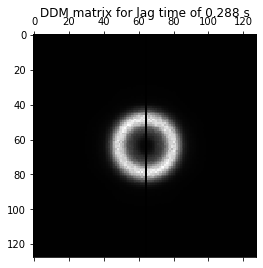

In [5]:
lagtime_for_ddmmatrix = 10
plt.matshow(ddm_calc.ddm_dataset.ddm_matrix_full[lagtime_for_ddmmatrix], cmap='gray')
plt.title("DDM matrix for lag time of %.3f s" % ddm_calc.ddm_dataset.lagtime[10])

The slice of the DDM matrix above looks pretty radially symmetric. This is expected as we are analyzing a video of silica particles diffusing randomly with no preferred direction. Because of this symmetry, we can radially average the DDM matrix to go from $D(q_x, q_y, \Delta t)$ to $D(q, \Delta t)$ where $q = \sqrt{q_x^2 + q_y^2}$. 

Let's plot a slice of this radially averaged DDM matrix $D(q, \Delta t)$ (which is stored as the variable `ddm_matrix` in the `ddm_dataset`).

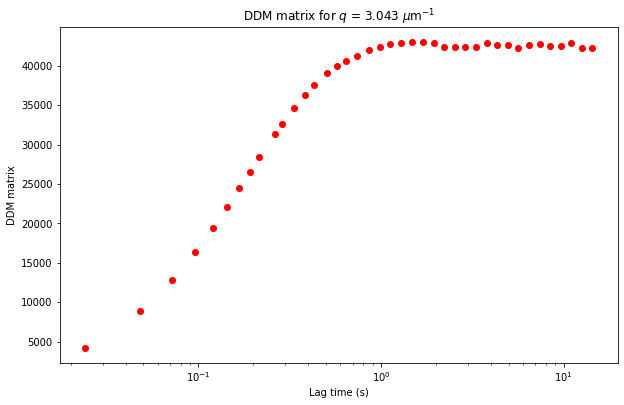

In [6]:
q_index = 15 #index of the list of q values
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ddm_matrix[:,q_index], 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("DDM matrix")
plt.title("DDM matrix for $q$ = %.3f $\mu$m$^{-1}$" % ddm_calc.ddm_dataset.q[q_index]);

#### Different data selecting methods

Since we are slicing this xarray dataset, let's use the opportunity to go over different ways of selecting data stored in a dataset. See the [xarray user guide](https://xarray.pydata.org/en/stable/user-guide/indexing.html) for more info. 

1. We can use the `isel` function (see [xarray.DataArray.isel](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.isel.html)). 
```python
q_index = 15 #index of the list of q values
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ddm_matrix.isel(q=q_index), 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("DDM matrix")
plt.title("DDM matrix for q = %.3f " % ddm_calc.ddm_dataset.q[q_index])
```

2. We can select the desired *q* not based on its **index** but on its actual **value** with `sel` (see [xarray.DataArray.sel](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html). Note that here we have to use `method = 'nearest'` since we do not have a *q* value of exactly 3 $\mu$m$^{-1}$.
```python
q_index = 15 #index of the list of q values
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ddm_matrix.sel(q=3, method='nearest'), 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("DDM matrix")
plt.title("DDM matrix for q = %.3f " % ddm_calc.ddm_dataset.q[q_index])
```

3. Lastly, we can create this plot (using whichever slicing method) with xarray's plotting function (which just wraps `matplotlib.pyplot`). For more, see [xarray.DataArray.plot](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html).
```python
q_index = 15
ddm_calc.ddm_dataset.ddm_matrix.isel(q=q_index).plot(xscale='log', marker='o', ls='none')
```

#### Determing the A and B parameters to get the ISF

Let's now look at the `avg_image_ft` data variable. This is a radially averaged average of all the Fourier transforms of the images. This function should equal $ (1/2) \times \left[ A(q) + B(q) \right] $. 

If we make the assumption that at the highest wavevectors (large $q$) the amplitude, $A(q)$, goes to zero, then we can estimate the background, $B$. If we also assume that the background is a constant that's independent of $q$, then we can determine $A(q)$. 

Plotted below is this `avg_image_ft` along with a horizontal line which we estimate to be **half** the background. This estimate is taken from the last 10% of the wavevectors. The background is saved to the `B` data variable. And then we can determine the amplitude which is saved as the `Amplitude` variable.

<IPython.core.display.Javascript object>


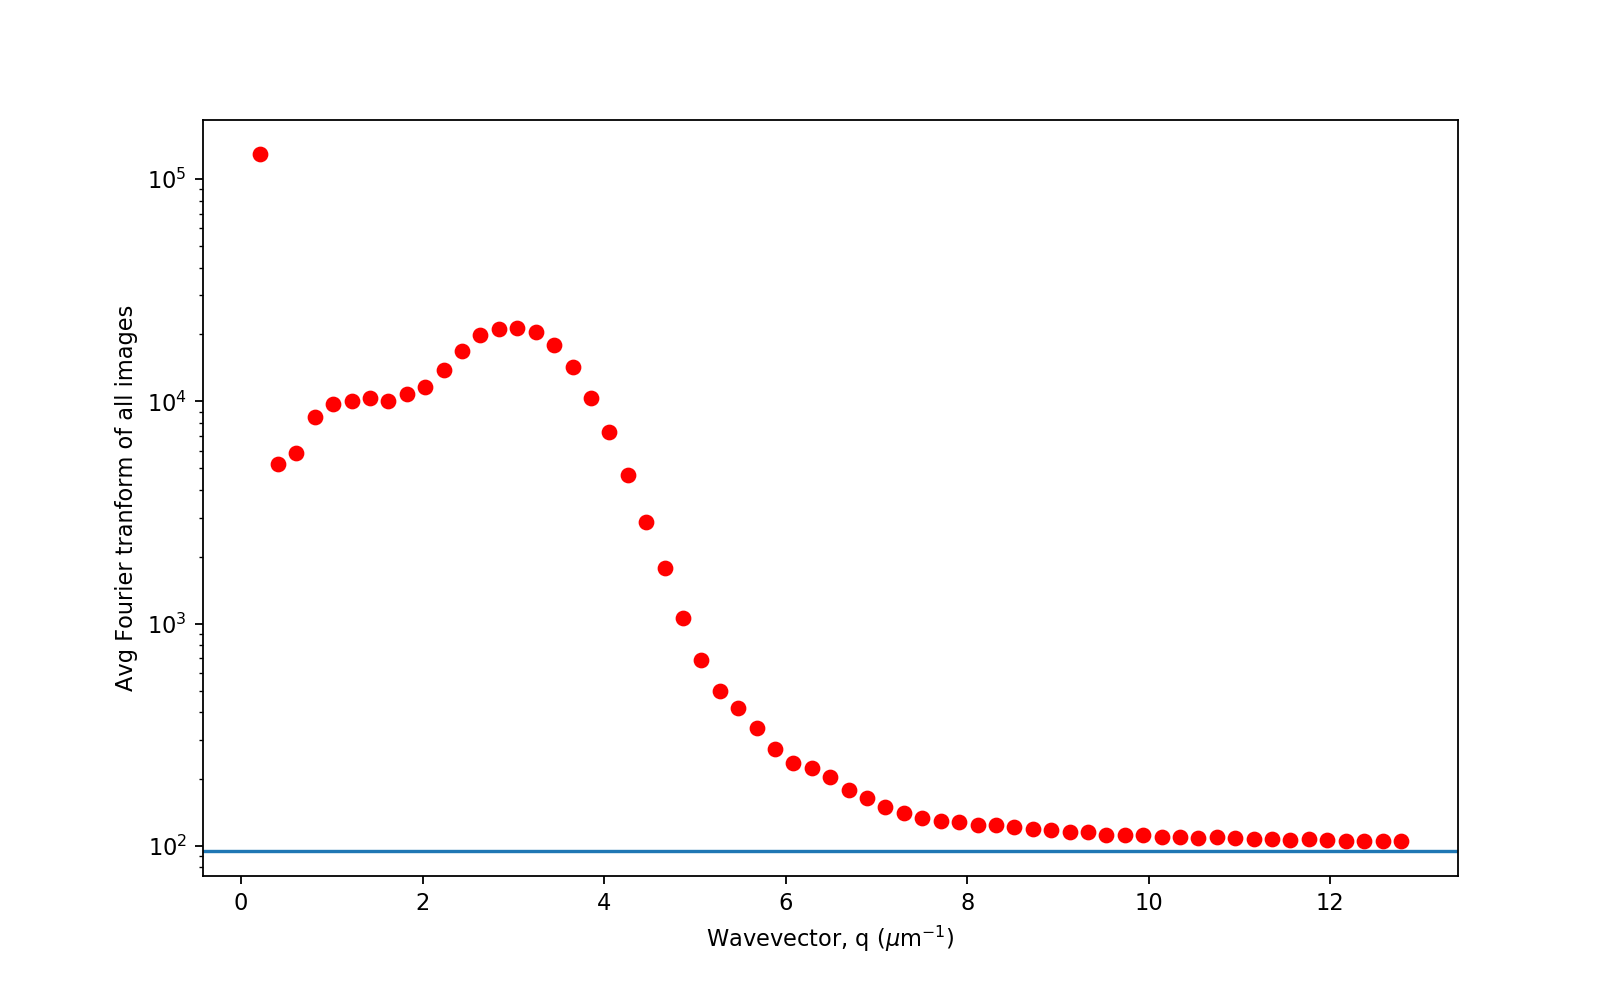

In [12]:
%matplotlib notebook
plt.figure(figsize=(10,10/1.618))
plt.semilogy(ddm_calc.ddm_dataset.q[1:], ddm_calc.ddm_dataset.avg_image_ft[1:], 'ro')
plt.xlabel("Wavevector, q ($\mu$m$^{-1}$)")
plt.ylabel("Avg Fourier tranform of all images")
plt.axhline(y = 0.5*ddm_calc.ddm_dataset.B)

If we know $A(q)$ and $B$, then we can find the intermediate scattering function, $f(q, \Delta t)$, by assuming that the DDM matrix is equal to $D (q, \Delta t) = A(q) \times \left[ 1 - f(q, \Delta t) \right] + B$. 

The ISF is stored as the data variable `ISF` in the `ddm_dataset`. 

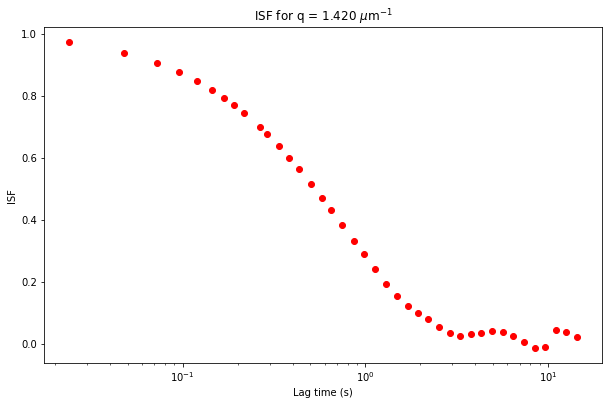

In [8]:
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ISF.sel(q=1.5, method='nearest'), 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("ISF")
plt.title("ISF for q = %.3f $\mu$m$^{-1}$" % ddm_calc.ddm_dataset.q.sel(q=1.5, method='nearest'));

#### Checking the background estimate

We expect the ISF to go from 1 to 0. We may not see exactly this behavior in the ISF for all wavevectors. At larger wavevectors, the dynamics might be fast and we might not be taking images fast enough to see the early decay of the ISF. Conversely, at lower wavevectors, the dynamics might be slow and we may not be able to calculate the ISF for large enough lag times to see it decay all the way to zero. Additionally, for non-ergodic dynamics, the ISF may **not** decay to zero but to some value sometimes referred to as the non-ergodicity parameter. 

But another reason that the ISF may not go from 1 to 0 is that we did a poor job in estimating the background, $B$. We try to estimate $B$ by looking at the average Fourier transforms of all the images, radially averaging that, and assuming that the amplitude goes to zero at large wavevectors. But another way to estimate $B$ is to look at the DDM matrix at large wavevectors, as is plotted below. 

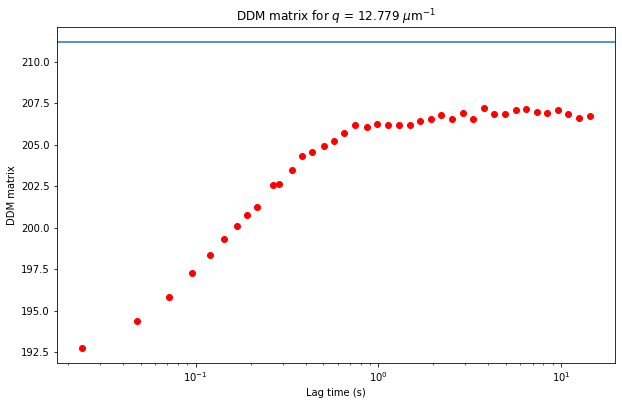

In [9]:
q_index = 63 #index of the list of q values
plt.figure(figsize=(10,10/1.618))
plt.semilogx(ddm_calc.ddm_dataset.lagtime, ddm_calc.ddm_dataset.ddm_matrix[:,q_index], 'ro')
plt.xlabel("Lag time (s)")
plt.ylabel("DDM matrix")
plt.title("DDM matrix for $q$ = %.3f $\mu$m$^{-1}$" % ddm_calc.ddm_dataset.q[q_index]);
plt.axhline(y = ddm_calc.ddm_dataset.B)

The DDM matrix should go from the background, $B$, to the background plus amplitude, $B + A$, as a function of the lag time. From the above plot, it does look like we overestimated the background (perhaps the amplitude hadn't gone quite to zero by the last wavevectors we measure?). From the plot, clearly the background is less than 195. 

Let's estimate the background at  about 190. We can make this adjustment with the `recalculate_ISF_with_new_background` function. 

In [10]:
new_ddm_matrix = ddm.recalculate_ISF_with_new_background(ddm_calc.ddm_dataset, 190)
display(new_ddm_matrix)

<xarray.Dataset>
Dimensions:           (frames: 40, lagtime: 40, q: 64, q_x: 128, q_y: 128, x: 128, y: 128)
Coordinates:
  * lagtime           (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
    framelag          (frames) int32 1 2 3 4 5 6 7 ... 308 352 402 459 525 599
  * q_y               (q_y) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q_x               (q_x) float64 -12.98 -12.78 -12.58 ... 12.37 12.58 12.78
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
Dimensions without coordinates: frames
Data variables:
    ddm_matrix_full   (lagtime, q_y, q_x) float64 194.5 183.5 ... 185.7 179.0
    ddm_matrix        (lagtime, q) float64 0.0 294.2 321.4 ... 206.7 206.2 206.7
    first_image       (y, x) float64 128.0 149.0 173.0 ... 175.0 229.0 215.0
    avg_image_ft      (q) float64 0.0 1.293e+05 5.225e+03 ... 105.3 104.7 105.3
    B                 int32 190
    B_std             float64 1.491
    num_pairs_per_dt  (lagtime) int32 2999 2998 2997 2996 ... 2541 2475 2401
    Amplitude         (q) float64 -190.0 2.585e+05 1.026e+04 ... 19.47 20.65
    ISF               (lagtime, q) float64 0.0 0.9996 0.9872 ... 0.1659 0.1911
Attributes:
    units:                   Intensity
    lagtime:                 sec
    q:                       μm$^{-1}$
    x:                       pixels
    y:                       pixels
    info:                    ddm_matrix is the averages of FFT difference ima...
    DataDirectory:           C:/Users/Ryan/Documents/GitHub/PyDDM/Examples/
    FileName:                images_nobin_40x_128x128_8bit.tif
    pixel_size:              0.242
    frame_rate:              41.7
    starting_frame_number:   no
    ending_frame_number:     no
    number_lagtimes:         40
    first_lag_time:          yes
    last_lag_time:           600
    crop_to_roi:             no
    split_into_4_rois:       no
    use_windowing_function:  no
    binning:                 no
    bin_size:                2
    central_angle:           no
    angle_range:             no

Now let's save this `ddm_dataset`. When the `calculate_DDM_matrix` method is executed, the `ddm_dataset` is automatically saved to disk. But we can overwrite that with the `resave_ddm_dataset` method. 

In [11]:
ddm_calc.resave_ddm_dataset(new_ddm_matrix)

## Initiazing DDM_Fit class and fitting our data to a model

We initlize the `DDM_Fit` class by passing it the yaml file containing our analysis parameters.

In [12]:
ddm_fit = ddm.DDM_Fit(ddm_calc.data_yaml)

,Initial guess,Minimum,Maximum
Amplitude,100.0,1.000,1000000.0
Tau,1.0,0.001,10.0
Background,25000.0,0.000,10000000.0
StretchingExp,1.0,0.500,1.1


Loading file C:/Users/Ryan/Documents/GitHub/PyDDM/Examples/images_nobin_40x_128x128_8bit_ddmmatrix.nc ...


Based on what was done above in terms of estimating the background, we found that $B$ should be about 190. We use that estimate of the background to determine $A(q)$ and the intermediate scattering function, $f(q,\Delta t)$. We could proceed to then fit the ISF. But here we choose not to. We fit the DDM matrix and have the amplitude and background, $A$ and $B$, be fitting parameters. But we can constrain these parameters based on what we found above. 

In [13]:
#We update the intial guess for the background and the lower and upper bounds
ddm_fit.set_parameter_initial_guess('Background', 190)
ddm_fit.set_parameter_bounds('Background', [10, 220])

Parameter 'Background' set to 190.
Parameter 'Background' lower limit set to 10.
Parameter 'Background' upper limit set to 220.


When we execute the fit below, we can use the optional argument `use_A_from_images_as_guess` set to True. This will use the value of $A(q)$ we esimated from the average Fourier tranform of all images and the estimated background. We can further limit the bounds on $A(q)$ with the optional parameter `update_limits_on_A` set to True. This will restrict the range that $A(q)$ can take to be within 10% of the estimated $A(q)$. If we want the bounds to be stricter or looser than 10%, we can change the optional parameter `updated_lims_on_A_fraction` to be something other than 0.1 (the default).

In [14]:
fit01 = ddm_fit.fit(name_fit = 'fit01', display_table=False, use_A_from_images_as_guess=True, update_limits_on_A=True)

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit01'.


In function 'get_tau_vs_q_fit', using new tau...
In hf.plot_one_tau_vs_q function, using new tau... 


<xarray.Dataset>
Dimensions:          (lagtime: 40, parameter: 4, q: 64)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 2.326e+05 ... 0.6837 0.7302
    theory           (lagtime, q) float64 10.0 315.0 290.4 ... 207.1 206.1 206.8
    isf_data         (lagtime, q) float64 ...
    ddm_matrix_data  (lagtime, q) float64 ...
    A                (q) float64 -190.0 2.585e+05 1.026e+04 ... 19.47 20.65
    B                int32 190
Attributes:
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.6869483430417769
    tau_vs_q_slope:                 [-1.82704423]
    msd_alpha:                      [1.09466425]
    msd_effective_diffusion_coeff:  [0.66295892]
    diffusion_coeff:                0.6273065478313061
    diffusion_coeff_std:            0.04682339946037524
    velocity:                       1.0610629560161529
    velocity_std:                   0.37807028285192074
    good_q_range:                   [4, 16]
    DataDirectory:                  C:/Users/Ryan/Documents/GitHub/PyDDM/Exam...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7

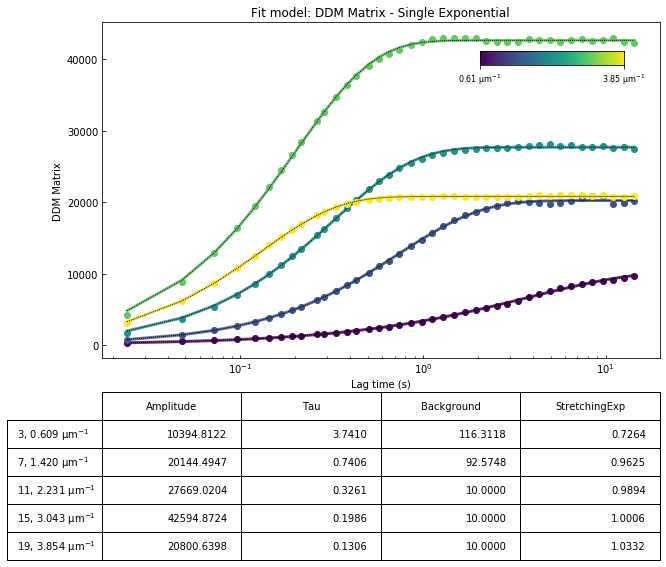

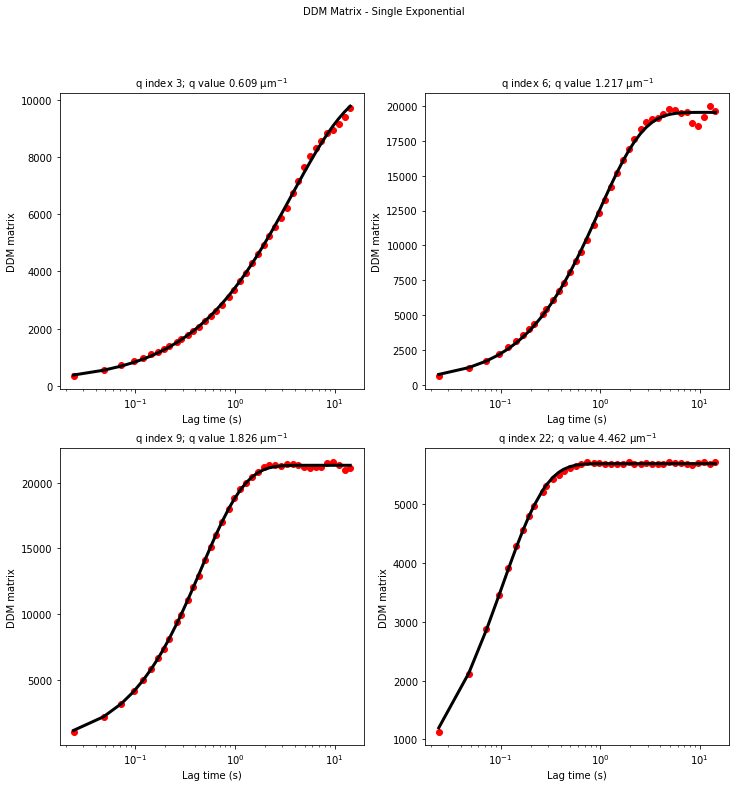

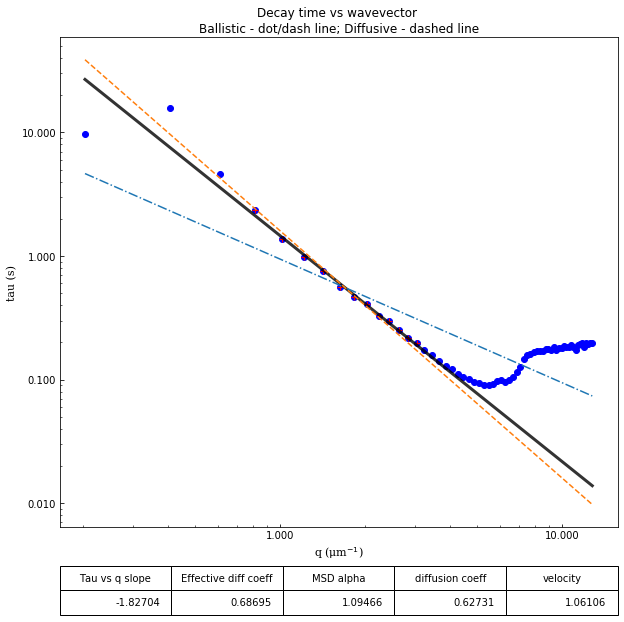

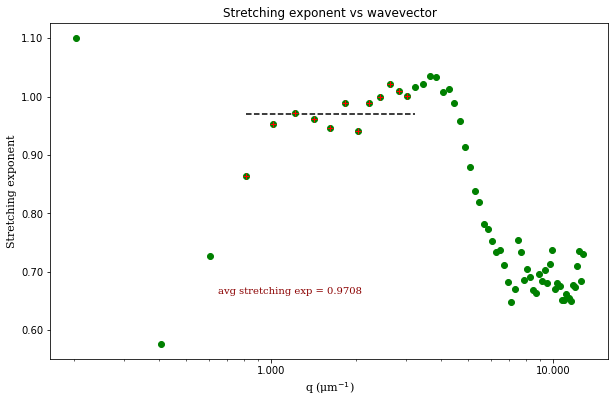

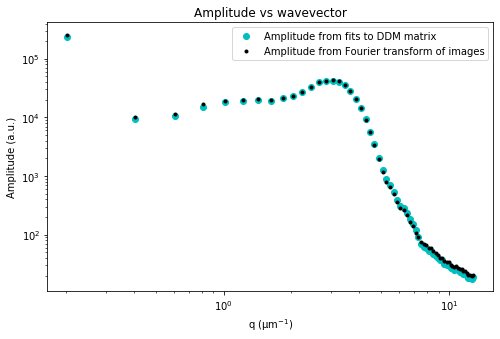

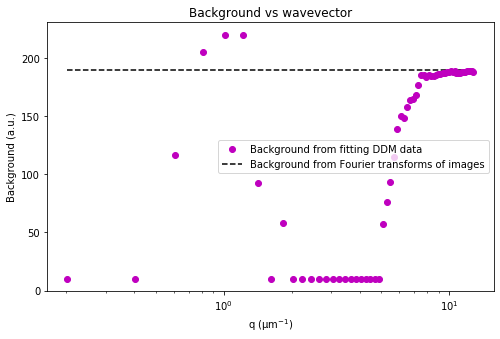

In [15]:
ddm.fit_report(fit01, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=True, show=True)

From the results of the fit, we can estimate a diffusion coefficient of about 0.6 $\mu m^2 / s$. We determine this by looking at the characteristic decay time vs the wavevector ($\tau$ vs $q$). On a log-log plot, power laws relationships between the two variables will come across as a straight line where the slope of the line is equal to the power. And, for this data, we see a clear power law show a relationship of $\tau \propto q^{-2}$ which indicates diffusive motion. Note that our data deviates from this power law relationship for $q$ greater than about 4 $\mu m^{-1}$. This could be due to poor optical resolution limiting the high wavevectors (which correspond to small length scales). Or it could be due to not having the temporal resolution necessary to detect fast decay times. Lastly, it could also be due to poor fit performance. We could try to use an initial guess for $\tau$ for each $q$ that is based on an estimated diffusion coefficient. That is, when we fit $D(q, \Delta t)$ (or $f(q,\Delta t)$), for each $q$, we will calculate $\tau_{guess} = 1 / (Dq^2)$ and use that as the initial guess in the fits. We do that below.

In [16]:
fit02 = ddm_fit.fit(name_fit = 'fit02', display_table=False, use_A_from_images_as_guess=True, update_limits_on_A=True,
                   update_tau_based_on_estimated_diffcoeff=True, estimated_diffcoeff=0.6, 
                   update_limits_on_tau=True, updated_lims_on_tau_fraction=1)

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit02'.


ddm.fit_report(fit02, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=False, show=True)

It doesn't appear that that helped much. In fact, we see that the $\tau$ values appear to be "hitting the rails" of the bounds we imposed on the parameter. 

Below, we plot $\tau$ vs $q$ for the last two fittings. We see that updating the initial guess didn't improve things. So the reason that the $\tau$ found for the high wavevectors is off does not seem to be related to the fitting algorithm using a poor initial guess. Perhaps at the high wavevectors the dynamics are too fast for us detect with the camera frame rate we used? Below we also plot a horizontal line corresponding the time interval between frames. We see that the fits are off even well above our temporal resolution. So it is also not the case that the fits at some of the high wavevectors is due to poor temporal resolution. 

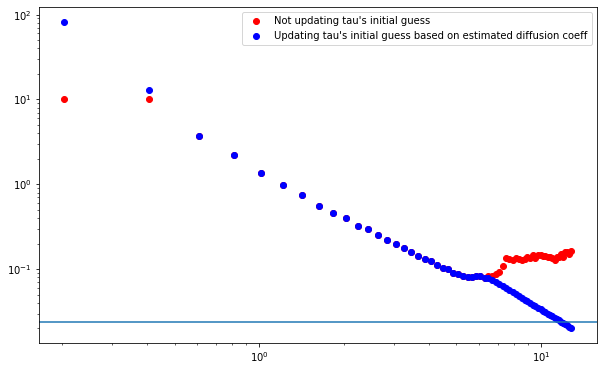

In [18]:
plt.figure(figsize=(10,10/1.618))
plt.loglog(fit01.q, fit01.parameters.loc['Tau'], 'ro', label="Not updating tau's initial guess")
plt.loglog(fit02.q, fit02.parameters.loc['Tau'], 'bo', label="Updating tau's initial guess based on estimated diffusion coeff")
plt.axhline(y = 1.0/fit01.frame_rate)
plt.legend(loc=0)

Let's try one more thing with this fitting. Let's think about the stretching exponent. For normal diffusive motion, we expect the intermediate scattering function to be a simple exponential: $f(q,\Delta t) = \exp(-\Delta t / \tau)$. But sometimes when the dynamics are heterogeneous or subdiffusion is present, we see that a stretched exponential works better. That is, for the ISF we use: $f(q,\Delta t) = \exp(-\Delta t / \tau)^s$ where $s$ is the stretching exponent. 

For this example data, we just have movie of silica colloidal particles diffusing in water. The dynamics should be diffusive. So we could try constraining the stretching exponent to be around to 1 as we expect (notice how the stretching exponent is between 0.6 and 0.7 for the high $q$ values in the previous fits).

In [19]:
#We update the intial guess for the background and the lower and upper bounds
ddm_fit.set_parameter_initial_guess('StretchingExp', 1)
ddm_fit.set_parameter_bounds('StretchingExp', [0.85, 1])

Parameter 'StretchingExp' set to 1.
Parameter 'StretchingExp' lower limit set to 0.85.
Parameter 'StretchingExp' upper limit set to 1.


In [20]:
fit03 = ddm_fit.fit(name_fit = 'fit03', display_table=False, use_A_from_images_as_guess=True, update_limits_on_A=True,
                   update_tau_based_on_estimated_diffcoeff=True, estimated_diffcoeff=0.6, 
                   update_limits_on_tau=True, updated_lims_on_tau_fraction=1)

In function 'get_tau_vs_q_fit', using new tau...
Fit is saved in fittings dictionary with key 'fit03'.


<xarray.Dataset>
Dimensions:          (lagtime: 40, parameter: 4, q: 64)
Coordinates:
  * parameter        (parameter) <U13 'Amplitude' 'Tau' ... 'StretchingExp'
  * q                (q) float64 0.0 0.2028 0.4057 0.6085 ... 12.37 12.58 12.78
  * lagtime          (lagtime) float64 0.02398 0.04796 0.07194 ... 12.59 14.36
Data variables:
    parameters       (parameter, q) float64 1.0 2.326e+05 ... 0.85 0.85
    theory           (lagtime, q) float64 10.0 78.85 276.8 ... 204.8 203.9 204.4
    isf_data         (lagtime, q) float64 ...
    ddm_matrix_data  (lagtime, q) float64 ...
    A                (q) float64 -190.0 2.585e+05 1.026e+04 ... 19.47 20.65
    B                int32 190
Attributes:
    model:                          DDM Matrix - Single Exponential
    data_to_use:                    DDM Matrix
    initial_params_dict:            ["{'n': 0, 'value': 100.0, 'limits': [1.0...
    effective_diffusion_coeff:      0.7141950420534895
    tau_vs_q_slope:                 [-1.78428624]
    msd_alpha:                      [1.12089639]
    msd_effective_diffusion_coeff:  [0.68571526]
    diffusion_coeff:                0.6485874982114271
    diffusion_coeff_std:            0.05859179376617822
    velocity:                       1.0789601548121792
    velocity_std:                   0.3572281855310629
    good_q_range:                   [4, 16]
    DataDirectory:                  C:/Users/Ryan/Documents/GitHub/PyDDM/Exam...
    FileName:                       images_nobin_40x_128x128_8bit.tif
    pixel_size:                     0.242
    frame_rate:                     41.7

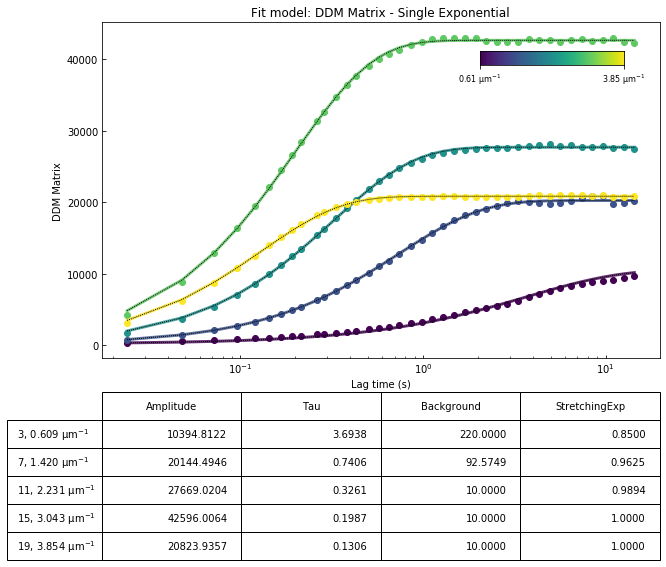

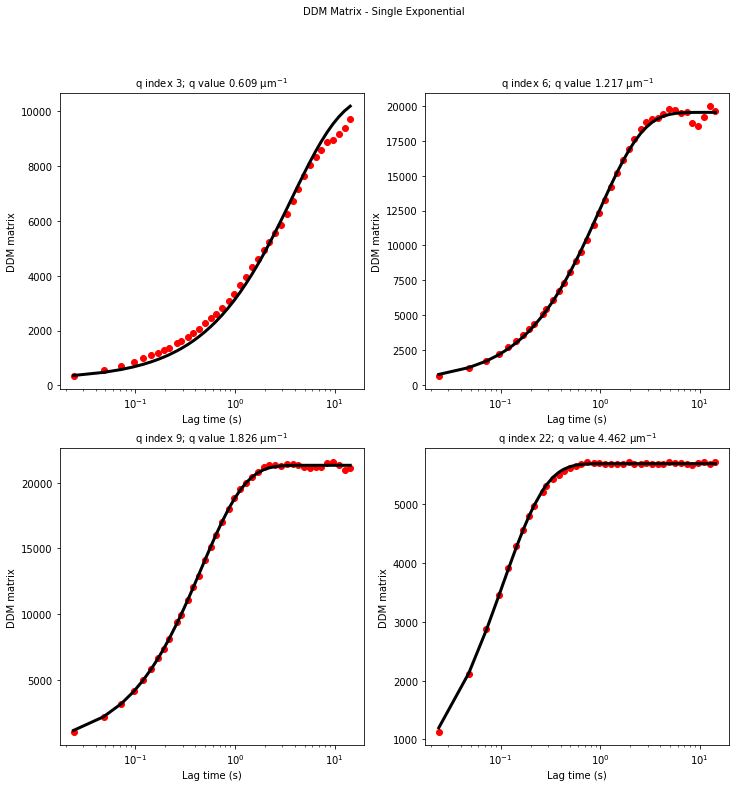

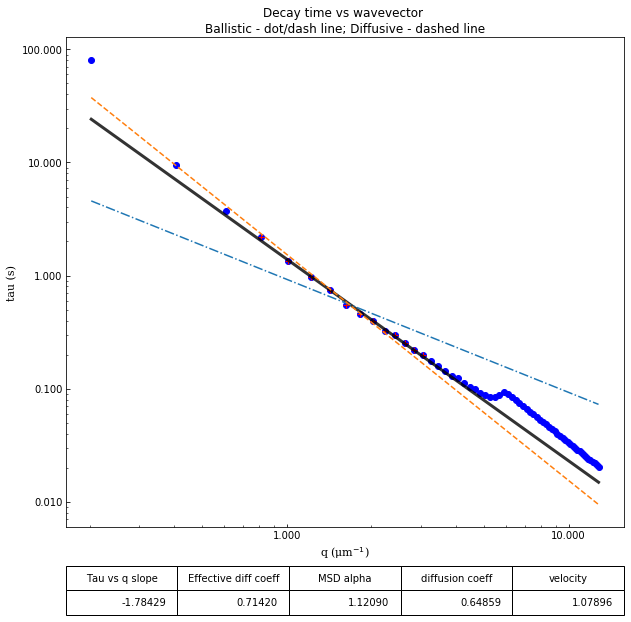

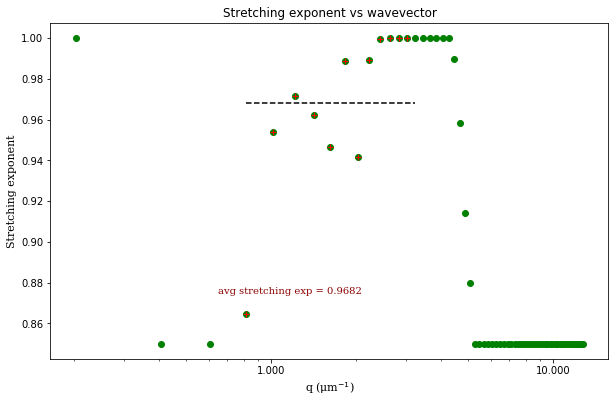

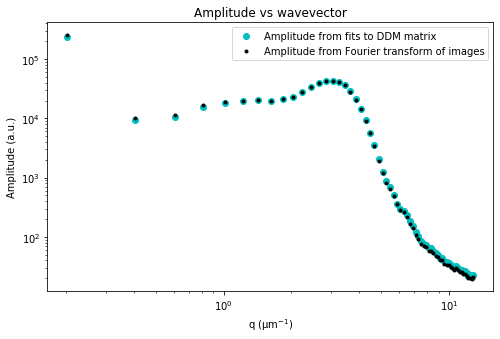

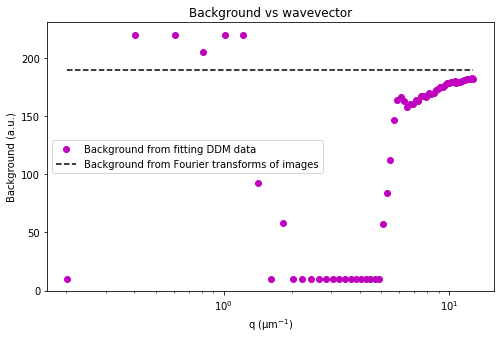

In [21]:
ddm.fit_report(fit03, q_indices=[3,6,9,22], forced_qs=[4,16], use_new_tau=False, show=True)

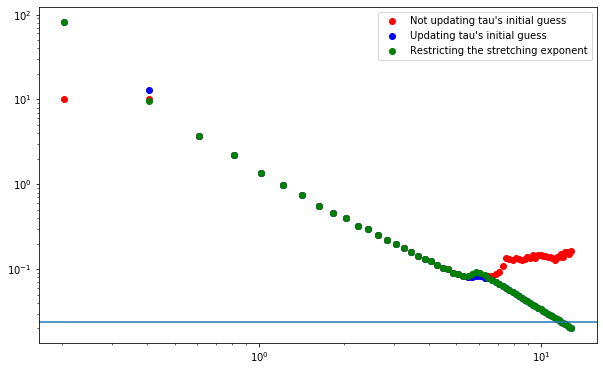

In [22]:
plt.figure(figsize=(10,10/1.618))
plt.loglog(fit01.q, fit01.parameters.loc['Tau'], 'ro', label="Not updating tau's initial guess")
plt.loglog(fit02.q, fit02.parameters.loc['Tau'], 'bo', label="Updating tau's initial guess")
plt.loglog(fit03.q, fit03.parameters.loc['Tau'], 'go', label="Restricting the stretching exponent")
plt.axhline(y = 1.0/fit01.frame_rate)
plt.legend(loc=0)

In [17]:
(2*np.pi)/6.

1.0471975511965976

## Interactive with matplotlib

<IPython.core.display.Javascript object>


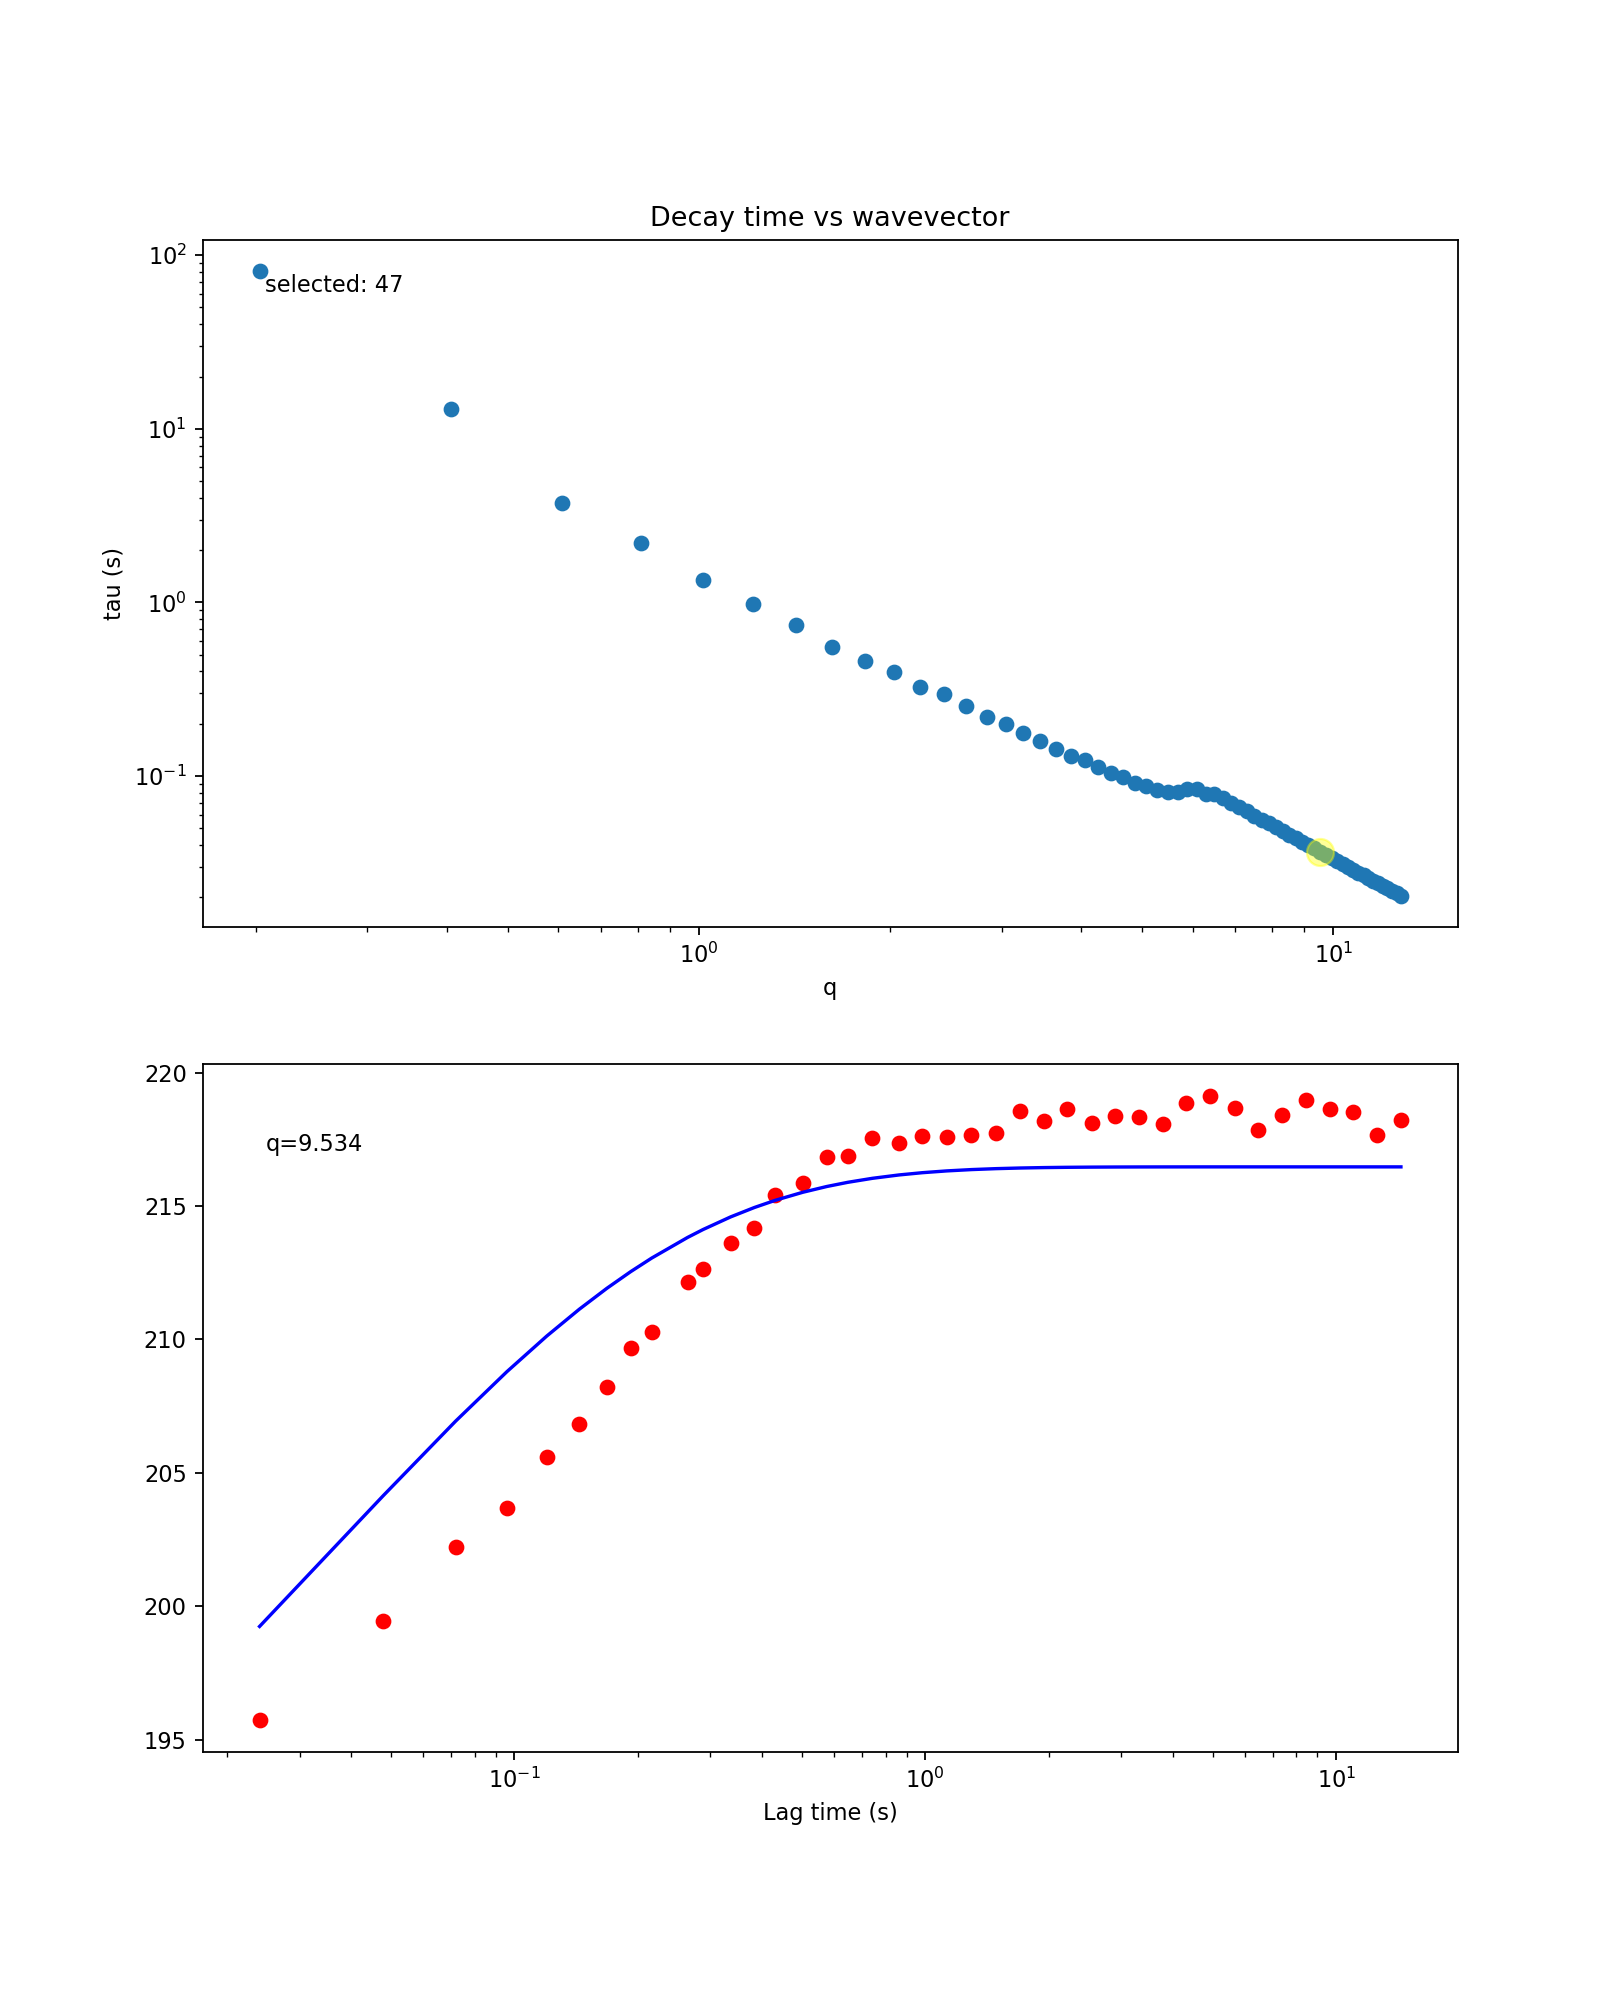

Click on a point in the tau vs q plot to see a fit.
Or press 'N' or 'P' to display next or previous fit.


Text(0, 0.5, 'tau (s)')

In [29]:
%matplotlib notebook
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10,2*10/1.618))
browser = ddm.Browse_DDM_Fits(fig, ax, ax2, fit02)

fig.canvas.mpl_connect('pick_event', browser.on_pick)
fig.canvas.mpl_connect('key_press_event', browser.on_press)

ax.set_title('Decay time vs wavevector')
ax.set_xlabel("q")
ax.set_ylabel("tau (s)")

## Saving the results

In [ ]:
ddm.save_fit_results_to_excel(fit01)

In [ ]:
fit01.to_netcdf("example_netcdf_file.nc")

In [ ]:
loaded_netcdf_file = xr.open_dataset("example_netcdf_file.nc")